# FBP demo 4 - FDK cone beam reconstruction with DAPHNE

-----------------------------------------------------------------------------------------------------------------------

<u>*The material provided in this notebook can be freely used and modified for educational purposes only. Please cite any content of the notebook as follows:*</u>

- *Panetta D, Camarlinghi N. 3D Image Reconstruction for CT and PET : A Practical Guide with Python. CRC Press; 2020. Available from: https://www.taylorfrancis.com/books/9780429270239*

*For questions, notifications of bugs, or even just for feedback, please contact the authors directly (daniele.panetta@ifc.cnr.it; niccolo.camarlinghi@gmail.com)*

-----------------------------------------------------------------------------------------------------------------------

### Introduction

This demo covers the topic of volumetric CT reconstruction in cone beam geometry. The case of flat detector (equispaced samples) will be taken into account.
Similarly to the previous demos in fan beam geometry using DAPHNE (FBP demo 3), the required steps can be summarised as follows:

1. Library import
2. Setting up the geometry
3. Loading the voxelized 3D Shepp-Logan head phantom (and displaying it)
4. Forward projecting the phantom using the Siddon method
5. Ramp filtering followed by cone beam backprojection of the projection data
6. Displaying the reconstructed image

The main preparatory steps and imports to begin are reported in the cell below.

In [1]:
import sys
import numpy as np
sys.path.append("../") # this to be able to include all the object contained in the modules
from Misc.Utils import Unpickle,ReadImage,DownscaleImage
from Misc.Preview import Visualize3dImage
import matplotlib.pyplot as plt
# set the default size of all the plots 5x5 inches
plt.rcParams['figure.figsize'] = [5, 5]
from Algorithms.SinogramGenerator import SinogramGenerator
from Algorithms.FBP import FBP
from Geometry.ExperimentalSetupCT import ExperimentalSetupCT,Mode,DetectorShape

%matplotlib notebook

### Create a CT experimental setup

Let's now create an experimental setup as done in the previous demos, in a pretty similar way of the FBP demo 3 in fan beam geometry. In this case the value of the ```mode``` member of ```my_experimental_setup``` must be set to ```Mode.CONEBEAM```. The chosen detector shape for this example is ```DetectorShape.PLANAR```.
SDD and SAD denote the source-to-detector and source-to-axis distances, respectively. As in the fan beam example, the actual size of the detector row is a derived parameter, calculated on top of ```pixels_per_slice_nb``` and ```fan_angle_deg```. The relationship between number of voxels, voxel size and volume size is the same as in the previous examples.

In [2]:
# create CT experimental setup
my_experimental_setup = ExperimentalSetupCT()
my_experimental_setup.mode = Mode.CONEBEAM
# detector 
my_experimental_setup.pixels_per_slice_nb=64
my_experimental_setup.detector_slice_nb=64
my_experimental_setup.slice_pitch_mm=4
my_experimental_setup.detector_shape=DetectorShape.PLANAR
# sources 
my_experimental_setup.sdd_mm=750
my_experimental_setup.sad_mm=500
my_experimental_setup.fan_angle_deg=40
# number of rotation of the gantry
my_experimental_setup.gantry_angles_nb = 360
# range of the rotation
my_experimental_setup.angular_range_deg = 360
# fov size in mm 
my_experimental_setup.image_matrix_size_mm = np.array([256,256,256])
# voxel size in mm
my_experimental_setup.voxel_size_mm = np.array([4,4,4])
# compute the geometry
my_experimental_setup.Update()
print(my_experimental_setup.GetInfo())

detector_type: DetectorType.CT
mode: Mode.CONEBEAM
pixels_per_slice_nb: 64
detector_slice_nb: 64
slice_pitch_mm: 4
detector_shape: DetectorShape.PLANAR
sdd_mm: 750
sad_mm: 500
fan_angle_deg: 40
gantry_angles_nb: 360
angular_range_deg: 360
image_matrix_size_mm: [256 256 256]
voxel_size_mm: [4 4 4]
number of projections: 1474560


You may have noticed that in this example, a voxel size of 4 mm has been chosen along each axis. Indeed, in order to keep the forward and back projection within reasonable time in this single-core, non parallelised educational implementation, we will use a rather coarse reconstruction grid.

### Display the experimental setup

As already done in the previous demos, let's look at the geometry using the ```Draw``` method:

In [3]:
my_experimental_setup.Draw(use_jupyter=0,camera_pos_mm=(0,-800,400))

### Load the image used to generate cone beam projection data

Let us now load another version of the voxelised 3D Shepp-Logan phantom, provided along with the example data. This version is stored in a grid of 256$^3$ voxels (let's assume that each voxel has a side of 1 mm in each direction).

<IPython.core.display.Javascript object>


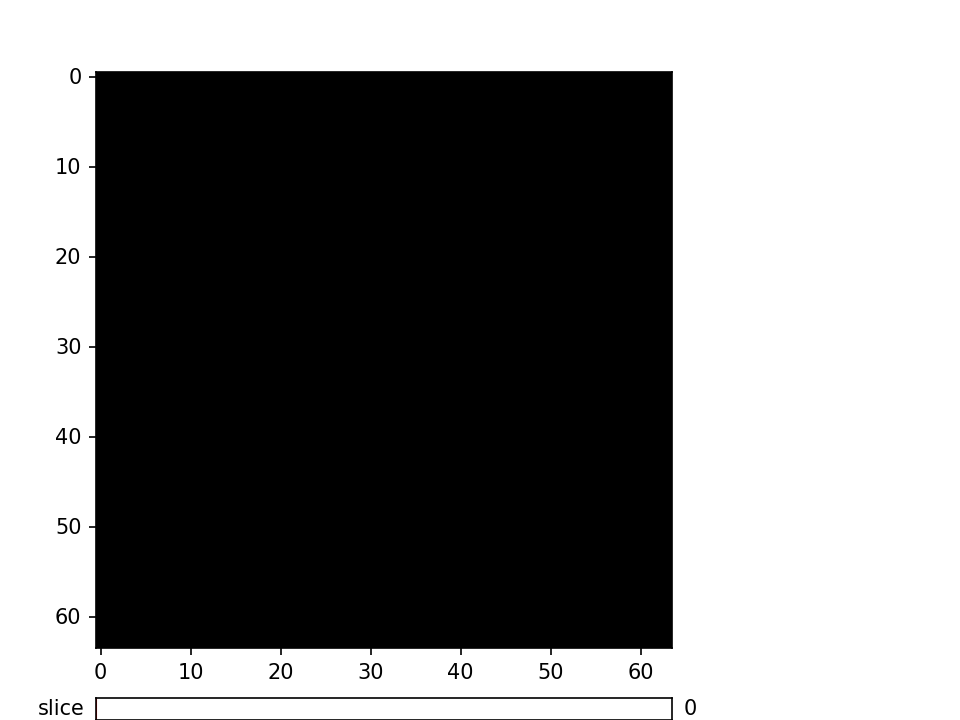

In [4]:
img = np.fromfile("../Data/SL3D_HC_256x256x256.bin", dtype=np.float32).reshape((256,256,256))
img = np.transpose(img, (1,2,0))

img=DownscaleImage(img,(4,4,4))
Visualize3dImage(img,2)


The function ```DownscaleImage``` used above allowed us to reduce the size of the phantom data, in order to keep the computation time of this example reasonably low. Of course, the reader is free to change this factor (as well as the other relevant geometric parameters involved) to see the effect on the final image.

### Generate and display the projection data

Also in cone-beam geometry, the interface of DAPHNE for generating projection data does not change with respect to other geometries:

In [5]:
s=SinogramGenerator(my_experimental_setup)
sino=s.GenerateObjectSinogram(img,transponse_image=1)

But let us now clarify the meaning of the term *sinogram* in the current geometry. We are actually generating a set of projections of the 3D object, giving rise to a 3D array of line integrals. The shape of the generated array follows the ordering: ```(n_of_radial_bins, n_of gantry_angles, n_of_bins_along_axial_direction)```. That is, the first two dimensions are those used in 2D sinograms as already seen in the previous example. But in cone-beam geometry, we often refer to projection data as *radiographs* of the 3D object, and hence we would like to visualise those data using the ordering ```(n_of_radial_bins, n_of_bins_along_axial_direction, n_of gantry_angles)```. This can be easily done with the ```Draw``` function by just putting ```slice_axis=1``` as the second argument (unlike the previous examples where ```slice_axis=2``` was used).

(64, 360, 64)


<IPython.core.display.Javascript object>


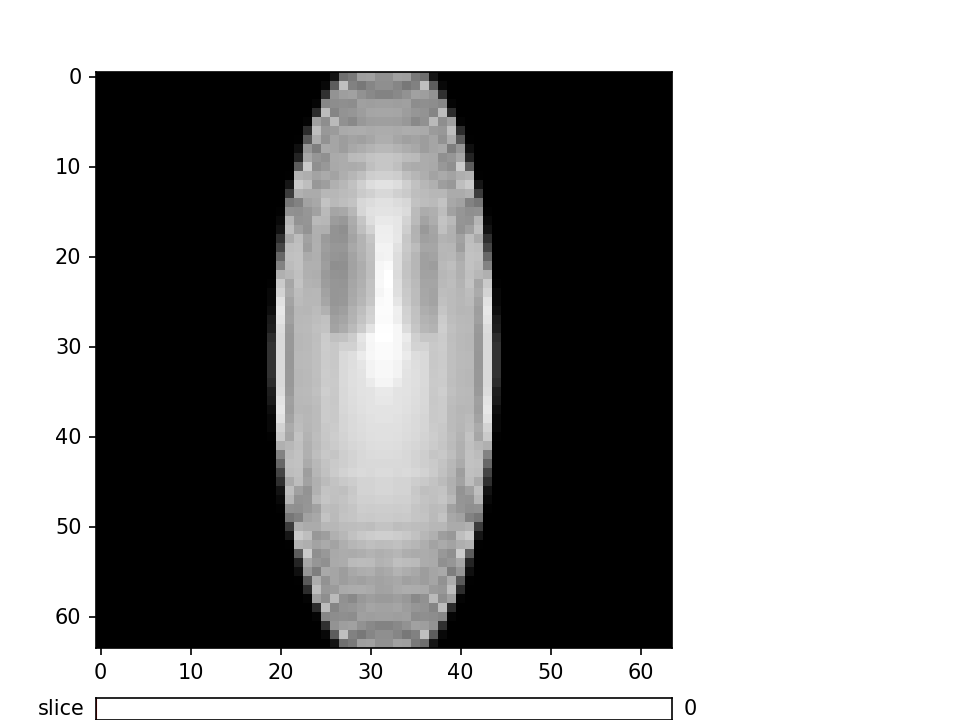

In [6]:
print(sino._data.shape)
Visualize3dImage(sino._data.T,1)


### Run the FDK algorithm and display the reconstructed image

With identical syntax of all the previous examples using DAPHNE, we are now ready to reconstruct the volumetric image. In this case, the underlying algorithm (embedded in the ```Reconstruct()``` function, will work in a rather different way as the cone-beam backprojection is performed angle-by-angle instead of slice-by-slice. The final result can be visualised as usual.

In [7]:
f=FBP()
f.sinogram=sino
# this is the interpolation for the backprojection 
# available options are : "linear","nearest","zero","slinear","quadratic","cubic"
# see for https://docs.scipy.org/doc/scipy/reference/generated/szerocipy.interpolate.interp1d.html parameter: kind
# for an explanation of the interpolation parameters  
f.interpolator='linear'
f.Reconstruct()


Generating ramp filter... 
done.

Filtering sinogram data... 
done.

Reconstruction done. 100% done...



<IPython.core.display.Javascript object>


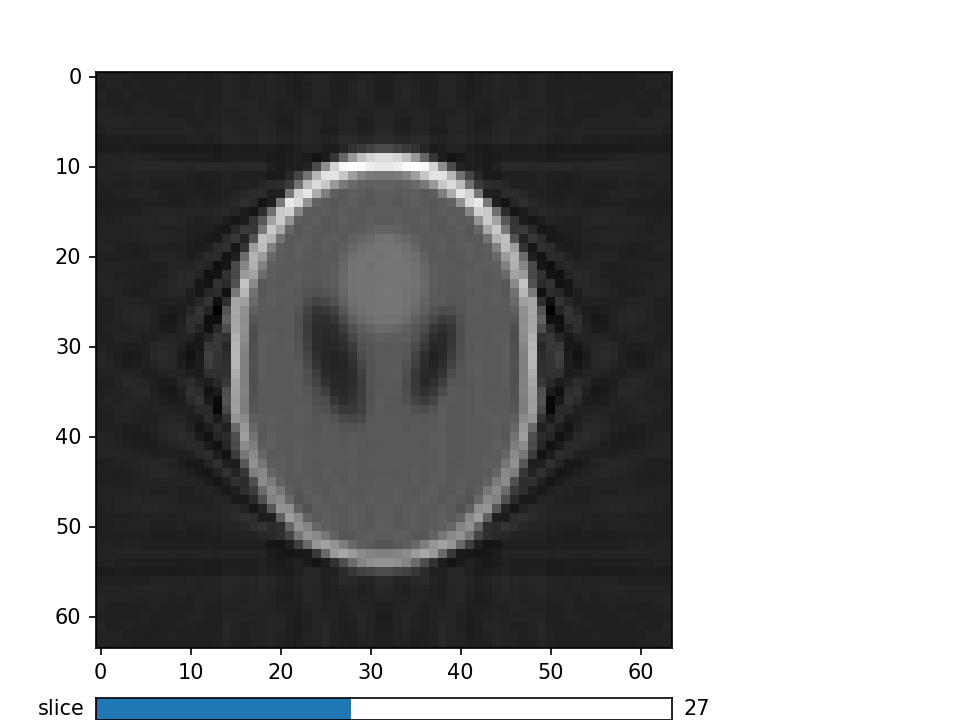

In [8]:
#Visualize3dImage(np.rot90(f._image.T),1)
Visualize3dImage(np.transpose(f._image,axes=(1,0,2)))                                                                   
     

As expected, the result is not very appealing due to the coarse projection grid used in this example. The reader can try to modify the notebook above by changing the relevant variables, such as the downsampling factor, the size of the projection grid, and so on.